In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

import dickandballs as db
import helpers as hel

# chiral eft

In [4]:
def downsample_array(array, target_size):
    """
    Downsample an array to the target size and return the downsampled array and the corresponding indices.
    
    Parameters:
    - array: The input array to downsample.
    - target_size: The target size for the downsampled array.

    Returns:
    - downsampled_array: The downsampled array.
    - indices: The indices used for downsampling.
    """
    total_size = len(array)
    indices = np.linspace(0, total_size - 1, target_size, dtype=int)
    downsampled_array = array[indices]
    return downsampled_array, indices

In [2]:
ceft_lower= np.loadtxt('EOS/ceft/eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt('EOS/ceft/eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T

n_ceft = n_ceft_lower/0.16 #n_sat

e_ceft = (e_ceft_lower+e_ceft_upper)/2
p_ceft = (p_ceft_lower+p_ceft_upper)/2


In [4]:
# downsampling
"""p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)
p_ceft_lower = p_ceft_lower[downed_indices]

e_ceft_upper = e_ceft_upper[downed_indices]
e_ceft_lower = e_ceft_lower[downed_indices]

n_ceft = n_ceft[downed_indices]

e_ceft = e_ceft[downed_indices]
p_ceft = p_ceft[downed_indices]"""


'p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)\np_ceft_lower = p_ceft_lower[downed_indices]\n\ne_ceft_upper = e_ceft_upper[downed_indices]\ne_ceft_lower = e_ceft_lower[downed_indices]\n\nn_ceft = n_ceft[downed_indices]\n\ne_ceft = e_ceft[downed_indices]\np_ceft = p_ceft[downed_indices]'

excluding the crust (n=0.076 fm^-3) because the uncertainty in the crust is way to low and that strongly influences how the gpr behaves (it conditions on the crust too heavily)

In [3]:
n_crust = n_ceft[:111]
e_crust = e_ceft[:111]
p_crust = p_ceft[:111]


p_ceft_upper = p_ceft_upper[111:]
p_ceft_lower = p_ceft_lower[111:]

e_ceft_upper = e_ceft_upper[111:]
e_ceft_lower = e_ceft_lower[111:]

n_ceft = n_ceft[111:]
e_ceft = e_ceft[111:]
p_ceft = p_ceft[111:]
mu_ceft = (e_ceft + p_ceft)/n_ceft

e_ini = e_ceft[0]
p_ini = p_ceft[0]
n_ini = n_ceft[0]
mu_ini = (e_ini + p_ini) / n_ini

e_crust_width = e_ceft_upper[0] - e_ceft_lower[0]
e_ini_sigma = hel.CI_to_sigma(e_crust_width, 75)

p_crust_width = p_ceft_upper[0] - p_ceft_lower[0]
p_ini_sigma = hel.CI_to_sigma(p_crust_width, 75)

mu_ini_sigma = e_ini_sigma + p_ini_sigma

In [4]:
(e_crust[-1] + p_crust[-1])/ n_crust[-1]

151.16331486186536

In [5]:
mu_ini

151.16999723481618

In [6]:
cs2_ceft_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_ceft_upper = np.gradient(p_ceft_upper, e_ceft_upper) #dp/de
cs2_ceft_avg = (cs2_ceft_upper+cs2_ceft_lower)/2
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = hel.CI_to_sigma(cs2_ceft_width, 75)

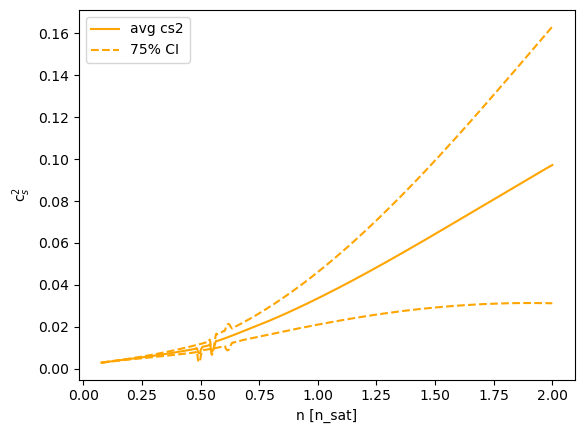

In [7]:
plt.plot(n_ceft, cs2_ceft_avg, color='orange', label='avg cs2')

plt.plot(n_ceft, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')


plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



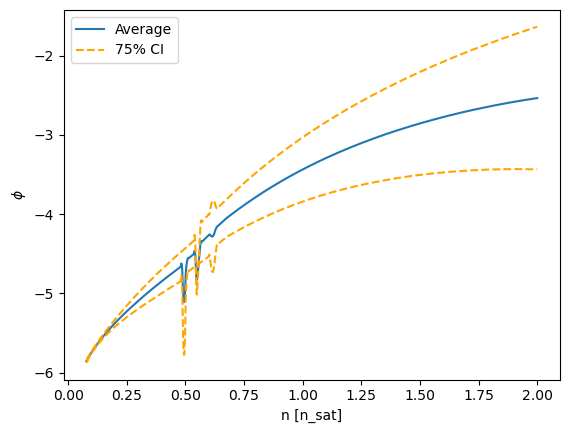

In [8]:
phi_ceft_lower = hel.get_phi(cs2_ceft_lower)
phi_ceft_upper = hel.get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = hel.CI_to_sigma(phi_ceft_width, 75)

plt.plot(n_ceft, phi_ceft_avg, label='Average')
plt.plot(n_ceft, phi_ceft_lower, "--", color='orange')
plt.plot(n_ceft, phi_ceft_upper, "--", color='orange', label='75% CI')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


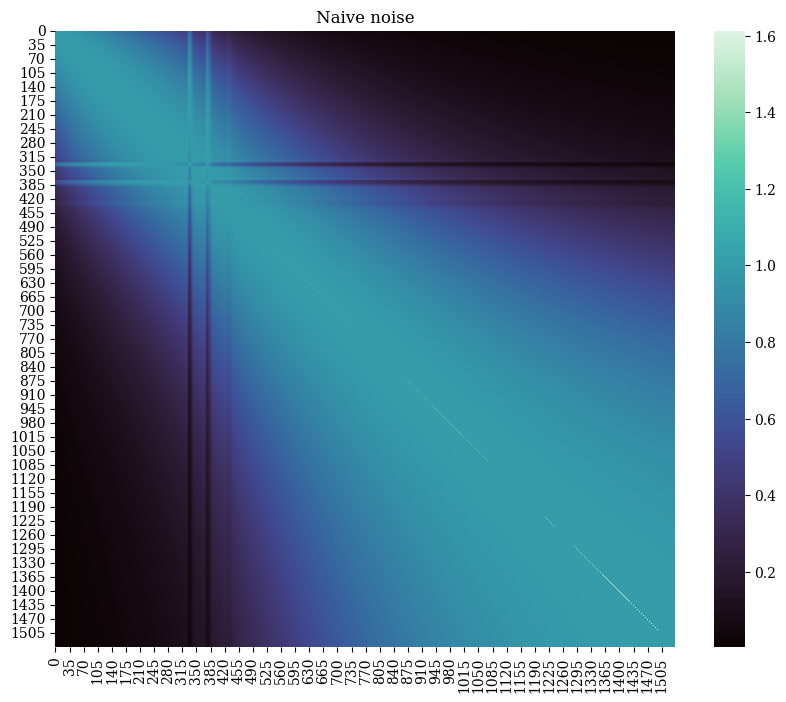

In [116]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(phi_ceft_avg)

noise_kern = K11 + np.diag(phi_ceft_sigma**2)
kern.visualise_kernel(noise_kern, 'Naive noise', annotation=False)


# GPR

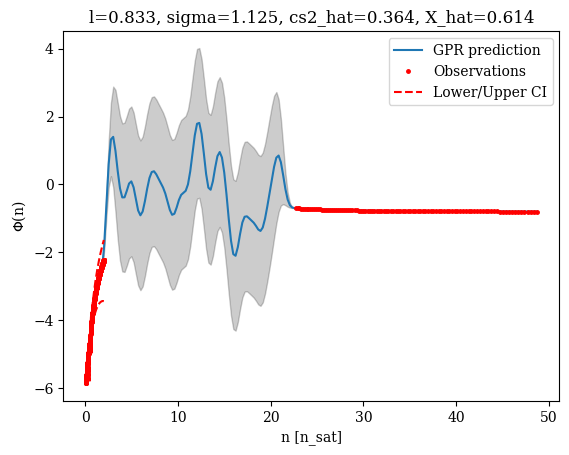

In [29]:
cs2_hat, nu_hat, l_hat, X_hat = hel.get_hype_samples()

kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = hel.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_ceft, n_pqcd))
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = hel.get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(n_ceft[0], n_pqcd[-1], 200) # number density, starting val is ending val of n crust


gp = db.GP(kernel, hel.get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")

plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')


plt.legend()
plt.show()



In [ ]:
from scipy.integrate import cumulative_simpson as cumsimp

integrand_pqcd = cs2_pqcd / n_pqcd
integral_pqcd = cumsimp(y=integrand_pqcd, x=n_pqcd, initial=0)

mu_pqcd = 2.2*np.exp(integral_pqcd) #self.mu_0 * np.exp(integral)

plt.plot(n_pqcd, mu_pqcd)
plt.xlabel("n [nsat]")
plt.ylabel("$\mu$[GeV]")
plt.show()

only until n=10 gpr

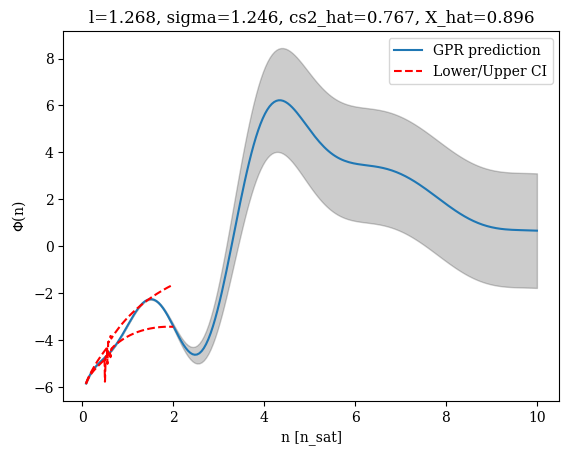

In [26]:
cs2_hat, nu_hat, l_hat, X_hat = hel.get_hype_samples()

kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = hel.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_ceft, n_pqcd))
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = hel.get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(n_ceft[0], 10, 200) # number density, starting val is ending val of n crust


gp = db.GP(kernel, hel.get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
#plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")

plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')


plt.legend()
plt.show()



# restricting to n=10 due to chem pot error

In [42]:
indices = np.where(x_test<=10)

n_useful = x_test[indices]
phi_useful = phi_test.flatten()[indices]

eos_useful = db.EosProperties(n_useful, phi_useful, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_results = eos_useful.get_all()

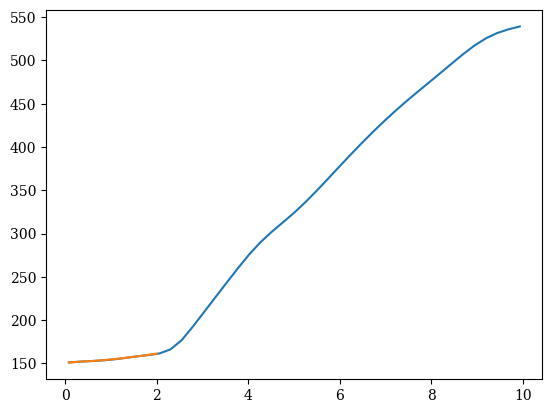

In [61]:
plt.plot(n_useful, eos_results["mu"])
plt.plot(n_ceft, mu_ceft, label="CEFT")



chemical potential error: $\mu$ from the GPR does not converge to $\mu$ at PQCD densities

# TOV Solver (migrate this to new notebook)

In [103]:
def correct_eos_units(e,p):
    """
    The units are MeV/fm^3. They need to be in km^-2.
    """
    MEVFM3_TO_KM2 = 1.3234e-6
    new_e = e * MEVFM3_TO_KM2
    new_p = p * MEVFM3_TO_KM2
    return new_e, new_p

In [209]:
def TOV_equations(r, y, epsilon_array, pressure_array):

    m,P = y

    if P<=0:
        return [0,0]
    

    epsilon = np.interp(P, pressure_array, epsilon_array)  # Interpolation done in this one line
    print(P)
    #epsilon = epsilon_array[np.argmax(pressure_array<=P)]

    dmdr = 4 * np.pi * r**2 * epsilon
    dPdr = (P + epsilon) * (m + 4*np.pi*r**3+P)/(r*(r-2*m))
    return np.array([dmdr, dPdr]) 


In [198]:
SOLAR_MASS_KM = 1.47766 # 1 Msol in km
epsilon_useful, pressure_useful = correct_eos_units(eos_results["epsilon"], eos_results["pressure2"])

In [199]:
from scipy.integrate import odeint, solve_ivp

def solve_tov(P_c, pressure_array, epsilon_array, r_min = 1e-5, r_max=30, num_points=1000):
    """
    Solves the TOV equations using odeint.
    Returns the neutron star's mass and radius.
    """
    r_values = np.linspace(r_min, r_max, num_points)  # Radial grid
    initial_conditions = np.array([0, P_c], dtype=float)


    sol = solve_ivp(
        fun=TOV_equations, t_span=[r_min, r_max], y0=initial_conditions, args=(pressure_array, epsilon_array),
        t_eval=r_values, method='RK45'
    )

    radii, masses, pressures = sol.t, sol.y[0], sol.y[1]

    # Find surface where pressure reaches zero
    surface_index = np.argmax(pressures <= 0)
    R_tot = r_values[surface_index]
    M_tot = masses[surface_index] / SOLAR_MASS_KM 

    return R_tot, M_tot

In [210]:
P_c = 1.77248454e-03

R, M = solve_tov(P_c, pressure_useful[::-1], epsilon_useful[::-1])
print(f"Neutron star properties: Radius = {R:.2f} km, Mass = {M:.2f} M_sun")

0.00177248454
0.0017902093854
0.0021269814480000017
0.0024784086804083023
0.006278205458164233
0.004992918607313817
0.012509366160654869
0.024775655959620193
0.0018926555994561078
0.001971575928366047
0.0024444936777210796
0.0025712588844647734
0.0027044970170524425
0.0026788364150486374
0.0029522767316987907
0.0031547163645676795
0.0045549235513947
0.004932670155701608
0.005421870860859787
0.005461116586613064
0.006707247420383221
0.008041304987025561
0.024466508228033874
0.011250143698171941
0.06983535156455602
0.21760803402516096
0.005768300768527439
0.005961783863111477
0.007073156171385605
0.007356086549357621
0.007655614454923759
0.00759647575541147
0.008190234379248245
0.00859545525338885
0.01112845934163987
0.011826569470834481
0.012577843151049942
0.012465711877367815
0.014795603380237046
0.017030796550728297
0.039884125612198625
0.03547497588095306
0.07009734914361411
0.11862815689401487
0.013369277814018171
0.01397362632832917
0.017666232922588336
0.01867112884314991
0.01973

# eos uncertainties

$$c_s^2 = \frac{1}{e^{-\phi}+1}$$ 
$$\sigma_{c_s^2} = |\frac{\partial {c_s^2}}{\partial \phi}| \sigma_{\phi} = \frac{e^{-\phi}}{(e^{-\phi}+1)^2}| \sigma_{\phi}$$

In [44]:
eos = db.EosProperties(x_test, phi_test, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_prop_results = eos.get_all()

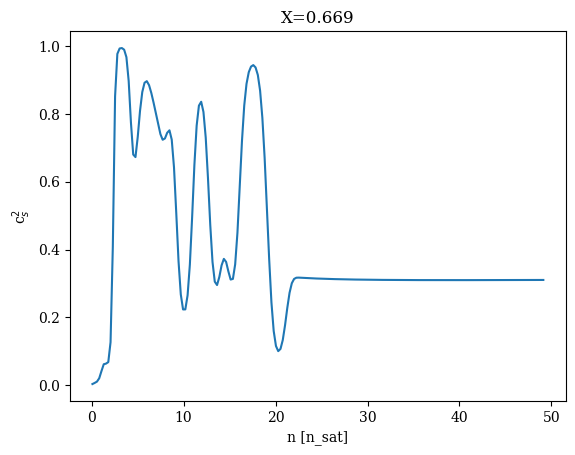

In [45]:
plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.title(f"X={X_hat:.3f}")
plt.show()

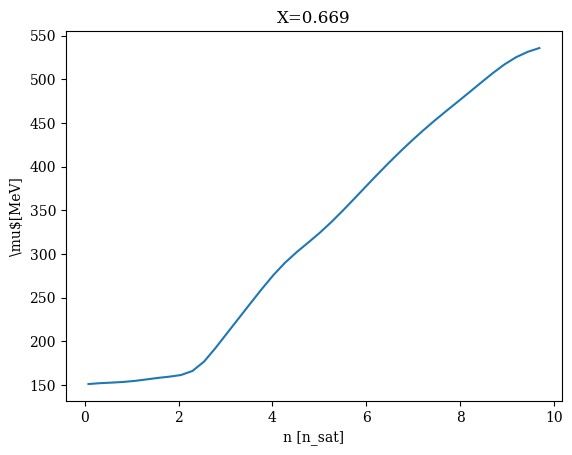

In [57]:
plt.plot(x_test[:40], eos_prop_results['mu'][:40])
plt.xlabel('n [n_sat]')
plt.ylabel(r'\mu$[MeV]')
plt.title(f"X={X_hat:.3f}")
plt.show()

In [13]:
def cs2_uncertainty(phi, sig_phi):
    phi = phi.flatten()
    sig_cs2 = np.abs(np.exp(-phi)/((np.exp(-phi)+1)**2)) * sig_phi
    return sig_cs2

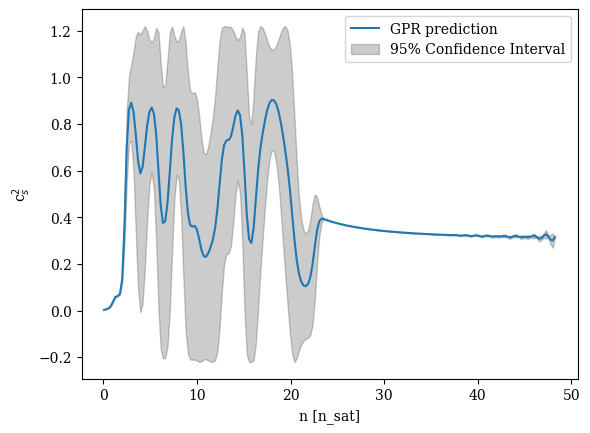

In [19]:
sig_cs2 = cs2_uncertainty(phi_test, sig)
plt.plot(x_test, eos_prop_results['cs2'], label='GPR prediction')
plt.fill_between(x_test, eos_prop_results['cs2'] - 1.96 * sig_cs2, eos_prop_results['cs2'] + 1.96 * sig_cs2, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.legend()

plt.show()

In [16]:
def mu_uncertainty(mu, mu0, sig_mu0, sig_cs2, n, n_init):
    """
    Calculate the uncertainty in mu (sigma_mu).

    Parameters:
    - mu: Array of mu values.
    - sig_cs2: Array of uncertainties in c_i^2 (sigma_c_i).
    - x_test: Array of n_i values.
    - delta_n: Array of Delta n_i values corresponding to each n_i.

    Returns:
    - sigma_mu: Array of uncertainties in mu (sigma_mu).

    See notebook on uncertainty
    """
    # Ensure all inputs are numpy arrays for efficient calculations
    mu = np.array(mu)
    sig_cs2 = np.array(sig_cs2)
    n = np.array(n)
    delta_n = np.diff(n, prepend=n_init)

    uncertainty_terms = (delta_n / n) * sig_cs2

    sigma_x2 = np.sum(uncertainty_terms**2)
    
    # Compute sigma_mu using the propagated uncertainty formula
    sigma_mu = ((mu*sigma_x2)+(sig_mu0 * mu/mu0))**0.5
    
    return sigma_mu


In [17]:
sig_mu = mu_uncertainty(eos_prop_results['mu'], mu_ini, mu_ini_sigma, sig_cs2, x_test, n_ini)

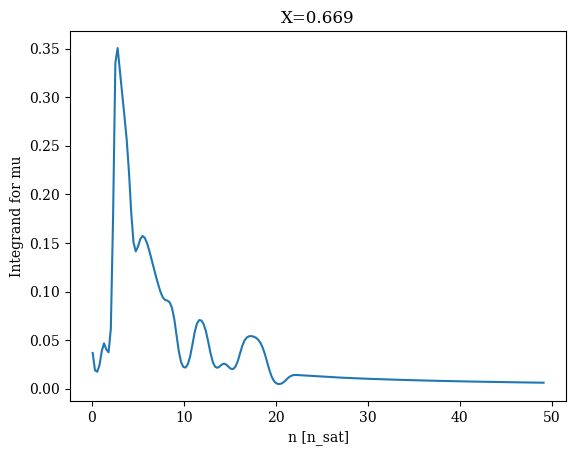

In [46]:
plt.plot(x_test, eos_prop_results['cs2']/x_test)
plt.xlabel('n [n_sat]')
plt.ylabel(r'Integrand for mu')
plt.title(f"X={X_hat:.3f}")
plt.show()

In [47]:
cs2_at_pqcd = eos_prop_results["cs2"][94:]
n_at_pqcd = x_test[94:]
from scipy.integrate import cumulative_trapezoid as cumtrap
integrand_at_pqcd = cs2_at_pqcd/n_at_pqcd
mu_at_pqcd = 2200*np.exp(cumtrap(y = integrand_at_pqcd, x= n_at_pqcd, initial=0))

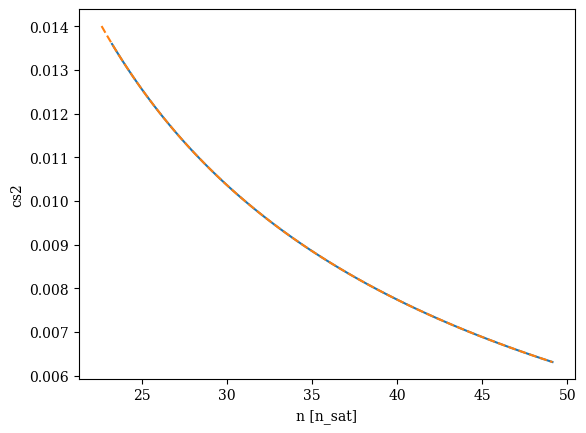

In [48]:
plt.plot(n_at_pqcd, cs2_at_pqcd/n_at_pqcd, label='GPR prediction')
plt.plot(n_pqcd, cs2_pqcd/n_pqcd, "--", label = 'pQCD')
plt.xlabel('n [n_sat]')
plt.ylabel('cs2')
plt.show()

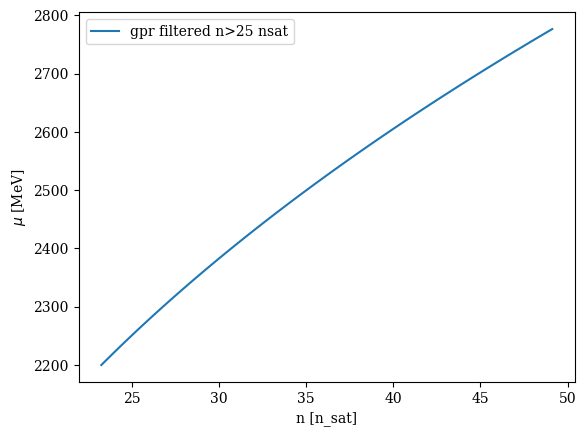

In [50]:
from pqcd.pQCD import pQCD

cs2_at_pqcd = eos_prop_results["cs2"][94:]
n_at_pqcd = x_test[94:]
from scipy.integrate import cumulative_trapezoid as cumtrap
integrand_at_pqcd = cs2_at_pqcd/n_at_pqcd
mu_at_pqcd = 2200*np.exp(cumtrap(y = integrand_at_pqcd, x= n_at_pqcd, initial=0))


mu_grid = np.linspace(2.2,2.8,100) #Grid in chemical potential in [GeV]

pQCD = pQCD(X_hat)
n_pQCD = np.vectorize(pQCD.number_density)(mu_grid)/0.16

#plt.plot(n_pQCD, mu_grid*1000, label = 'pQCD calculation')
plt.plot(n_at_pqcd, mu_at_pqcd, label='gpr filtered n>25 nsat')

plt.xlabel("n [n_sat]")
plt.ylabel("$\mu$ [MeV]")
plt.legend()
plt.show()

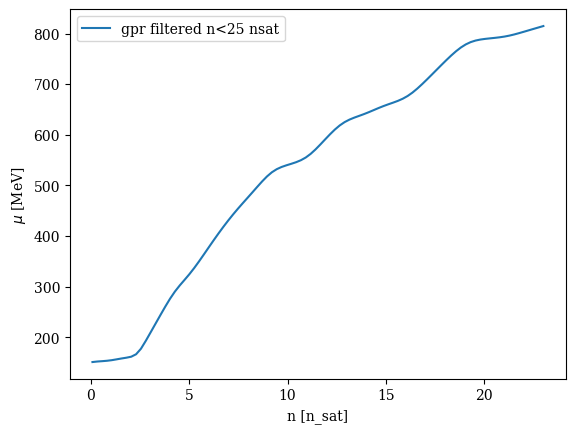

In [51]:
from pqcd.pQCD import pQCD

cs2_before_pqcd = eos_prop_results["cs2"][:94]
n_before_pqcd = x_test[:94]
from scipy.integrate import cumulative_trapezoid as cumtrap
integrand_before_pqcd = cs2_before_pqcd/n_before_pqcd
mu_before_pqcd = 151*np.exp(cumtrap(y = integrand_before_pqcd, x= n_before_pqcd, initial=0))


mu_grid = np.linspace(2.2,2.8,100) #Grid in chemical potential in [GeV]

pQCD = pQCD(X_hat)
n_pQCD = np.vectorize(pQCD.number_density)(mu_grid)/0.16

#plt.plot(n_pQCD, mu_grid*1000, label = 'pQCD calculation')
plt.plot(n_before_pqcd, mu_before_pqcd, label='gpr filtered n<25 nsat')

plt.xlabel("n [n_sat]")
plt.ylabel("$\mu$ [MeV]")
plt.legend()
plt.show()

In [53]:
eos_prop_results['mu'][0]

151.16999723481618

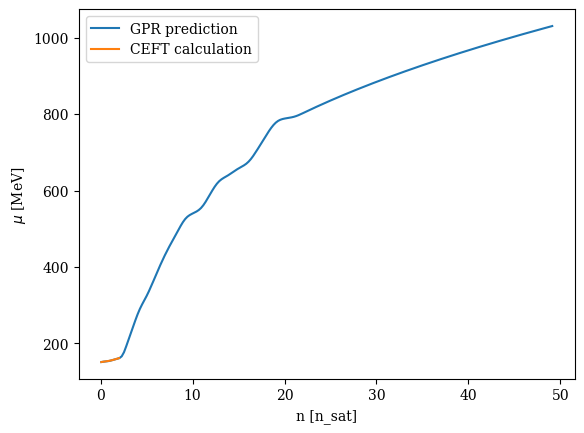

In [54]:
plt.plot(x_test, eos_prop_results['mu'], label='GPR prediction')
#plt.fill_between(x_test, eos_prop_results['mu'] - 1.96 * sig_mu, eos_prop_results['mu'] + 1.96 * sig_mu, alpha=0.2, color='k', label='95% Confidence Interval')
#plt.plot(n_at_pqcd, mu_at_pqcd, label='GPR filtered: n>25nsat')

#plt.plot(n_pqcd, mu_grid*1000, label = "pQCD input")
#plt.plot(x_test[94:], 3*eos_prop_results["mu"][94:], label= "3$\mu$ after n>25")
plt.plot(n_ceft, mu_ceft, label="CEFT calculation")
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$ [MeV]')
plt.legend()
plt.show()



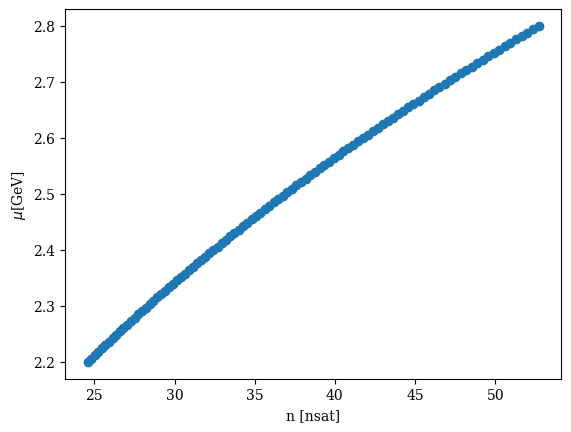

In [174]:
from scipy.integrate import cumulative_simpson as cumsimp

integrand_pqcd = cs2_pqcd / n_pqcd
integral_pqcd = cumsimp(y=integrand_pqcd, x=n_pqcd, initial=0)

mu_pqcd = 2.2*np.exp(integral_pqcd) #self.mu_0 * np.exp(integral)

plt.scatter(n_pqcd, mu_pqcd)
plt.plot(n_pQCD, mu_grid)

plt.xlabel("n [nsat]")
plt.ylabel("$\mu$[GeV]")
plt.show()

In [61]:
from scipy.integrate import cumulative_simpson as cumsimp

def integrate_mu(cs2, n, mu_0, mu_final):
    """
    Perform numerical integration of cs2 / n and compute mu using the initial and final values of mu.
    
    Parameters:
    cs2 (array): Array of cs2 values.
    n (array): Array of n values.
    mu_0 (float): Initial value of mu.
    mu_final (float): Final value of mu.
    
    Returns:
    array: Integrated values of mu.
    """
    integrand = cs2 / n
    integral = cumsimp(y=integrand, x=n, initial=0)

    mu = mu_0 * np.exp(integral)

    # Adjust the final value of mu to match mu_final
    mu_adjusted = mu * (mu_final / mu[-1])
    return mu_adjusted

In [103]:
import numpy as np
from scipy.integrate import odeint

def integrate_mu_with_constraints(cs2, n, mu_0, mu_final):
    """
    Integrates the differential equation for mu(n) while satisfying both the initial condition mu(n[0]) = mu_0
    and the final condition mu(n[-1]) = mu_final.
    
    The differential equation is assumed to be:
        d(mu)/dn = (cs2(n)/n) * mu
    where cs2 is given as an array corresponding to each value in n.

    Parameters:
      cs2 (array): Array of cs2 values (same length as n).
      n (array): Array of n values (strictly increasing).
      mu_0 (float): Initial value of mu at n[0].
      mu_final (float): Final value of mu at n[-1].

    Returns:
      array: Integrated values of mu across n.
    """

    # To handle cs2 properly, we interpolate it in case odeint calls the derivative function
    # at n values that are not exactly in the array.
    cs2_interp = lambda n_val: np.interp(n_val, n, cs2)

    # Define the forward ODE: d(mu)/dn = (cs2(n)/n)*mu
    def dmu_dn(mu, n_val):
        # mu is an array with one element, so return an array of the same shape
        return [(cs2_interp(n_val) / n_val) * mu[0]]

    # Forward integration from n[0] to n[-1]
    # Wrap the initial condition in a list to satisfy odeint's expectation.
    forward_solution = odeint(dmu_dn, [mu_0], n).flatten()

    # Define the reverse ODE: d(mu)/dn = -(cs2(n)/n)*mu for backward integration.
    def dmu_dn_reverse(mu, n_val):
        # Return an array of the same shape as mu
        return [-(cs2_interp(n_val) / n_val) * mu[0]]

    # Backward integration from n[-1] to n[0]
    backward_solution = odeint(dmu_dn_reverse, [mu_final], n[::-1]).flatten()[::-1]

    # Blend the two solutions. For example, use linear weights from 0 to 1:
    #weights = np.linspace(0, 1, len(n))
    #mu_combined = (1 - weights) * forward_solution + weights * backward_solution
    weights = 1 / (1 + np.exp(-10 * (n - n[len(n) // 2])))
    mu_combined = (1 - weights) * forward_solution + weights * backward_solution

    plt.plot(n, forward_solution, label="Forward Solution")
    plt.plot(n, backward_solution[::-1], label="Backward Solution")
    plt.legend()
    plt.show()

    return mu_combined


In [100]:
mu_ceft = (e_ceft+p_ceft)/n_ceft

In [53]:
def epsilon_uncertainty(epsilon, sigma_epsilon0, sigma_mu, n, n_init):
    n = np.array(n)
    delta_n = np.diff(n, prepend=n_init)

    cumulative_uncertainty_squared = 0.0
    sigma_epsilon = np.zeros(len(epsilon))

    for i in range(len(epsilon)):
        cumulative_uncertainty_squared += (sigma_mu[i] * delta_n[i])**2
        sigma_epsilon[i] = np.sqrt(sigma_epsilon0**2 + cumulative_uncertainty_squared)

    return sigma_epsilon

In [54]:
sig_epsilon = epsilon_uncertainty(eos_prop_results['epsilon'], e_ini, sig_mu, x_test, n_ini)

In [55]:
def sigma_cov(x,y):
    n = len(x)
    sig = 1/n * np.sum((x-np.mean(x))*(y-np.mean(y)))
    return sig

In [56]:
sigma_cov(eos_prop_results["cs2"], eos_prop_results["mu"])

-6.525684784661569

In [57]:
from scipy.integrate import cumulative_simpson as cumsimp

def p_uncertainty(p0, sigma_p0, p, epsilon, epsilon_0, mu, mu_0, sigma_mu, cs2, sigma_cs2, n):
    """
    Calculate the propagated uncertainty in p = p0 + integral(cs2 * mu dn).

    Parameters:
    - p0: Initial value of p.
    - sigma_p0: Uncertainty in p0.
    - p: Array of precomputed p values.
    - epsilon: Array of cumulative integral values for mu (epsilon).
    - epsilon_0: Initial value of epsilon (epsilon_0).
    - mu: Array of mu values.
    - mu_0: Initial value of mu.
    - sigma_mu: Array of uncertainties in mu.
    - cs2: Array of cs2 values.
    - sigma_cs2: Array of uncertainties in cs2.
    - n: Array of n values (integration variable).

    Returns:
    - sigma_p: Uncertainty in p.
    """
    # Calculate integrals from the given data
    integral_cs2_mu = p - p0  # Integral of cs2 * mu (already computed as p - p0)
    integral_mu = epsilon - epsilon_0  # Integral of mu (from epsilon)
    integral_cs2 = cumsimp(y=cs2, x=n, initial=np.log(mu_0))  # Integral of cs2

    # Partial derivatives
    partial_mu = integral_cs2  # ∂p/∂mu = ∫cs2 dn
    partial_cs2 = integral_mu  # ∂p/∂cs2 = ∫mu dn

    sigma_cs2_mu = sigma_cov(cs2, mu)

    # Propagate uncertainty
    sigma_p_squared = (
        sigma_p0**2 +                               # Contribution from p0
        (partial_mu**2) * sigma_mu**2 +             # Contribution from mu
        (partial_cs2**2) * sigma_cs2**2 +           # Contribution from cs2 <- largest
        2 * np.abs(partial_mu * partial_cs2) * (sigma_mu*sigma_cs2) # Covariance term, note it is the upper bound
    )
    sigma_p = np.sqrt(sigma_p_squared)

    return sigma_p


In [58]:
sig_p = p_uncertainty(p_ini, 
                      p_ini_sigma, 
                      eos_prop_results["pressure2"], 
                      eos_prop_results["epsilon"], 
                      e_ini, 
                      eos_prop_results["mu"], 
                      mu_ini, 
                      mu_ini_sigma, 
                      eos_prop_results["cs2"], 
                      sig_cs2, 
                      x_test)

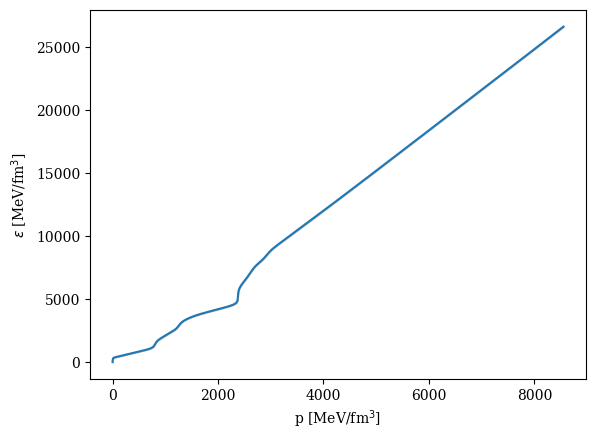

In [59]:
plt.plot( eos_prop_results["pressure2"], eos_prop_results["epsilon"],)
plt.ylabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.xlabel(r'p [MeV/fm$^3$]')

plt.fill_between(eos_prop_results["pressure2"], eos_prop_results['epsilon'] - 1.96 * sig_epsilon, eos_prop_results['epsilon'] + 1.96 * sig_epsilon, alpha=0.2, color='k', label='95% Confidence Interval')

plt.show()    

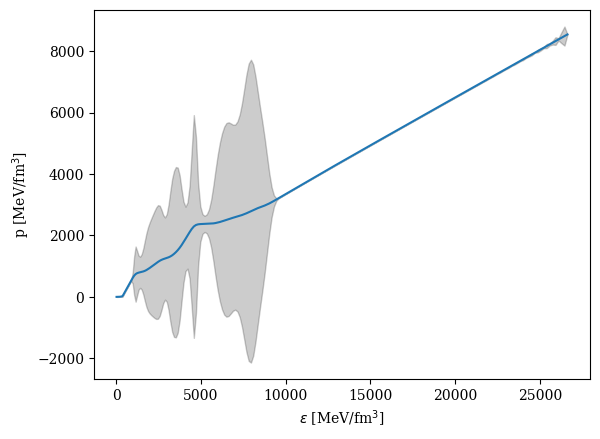

In [60]:
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure2"])
plt.xlabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.ylabel(r'p [MeV/fm$^3$]')

plt.fill_between(eos_prop_results["epsilon"], eos_prop_results['pressure2'] - 1.96 * sig_p, eos_prop_results['pressure2'] + 1.96 * sig_p, alpha=0.2, color='k', label='95% Confidence Interval')

plt.show()    